# 🧠 Motor Imagery Classifier — 2 Classes (Left vs Right)

**Goal:** Train and evaluate a binary MI classifier *(left-hand vs right-hand imagery)*.

---

## 🔁 Unit of Generalization

- **Unseen runs (within-subject):**  
  - Split **by run** *inside each subject*.  
  - Train on some runs, **test on held-out runs** of the **same** subject.

- **Unseen subjects (LOSO):**  
  - Split **by subject** using `GroupKFold` / `LeaveOneGroupOut`.  
  - Train on all but one subject, **test on the held-out subject**.

> Tip: Keep `X`, `y`, and `groups` aligned so that `groups` encodes **run IDs** for within-subject splits and **subject IDs** for LOSO.

---

## 📏 Evaluation Metrics

- **Accuracy** — standard proportion of correct predictions.
- **Cohen’s κ** — chance-corrected agreement (more robust under class imbalance).

> Report **mean ± SD** across folds for both metrics.

---

## ✅ Reporting Checklist

- [ ] Clearly state whether results are for **unseen runs** or **unseen subjects**.  
- [ ] Use the **same preprocessing** in train/test (fit transformers on *train only*).  
- [ ] Preserve **group boundaries** in CV splits.  
- [ ] Report **Accuracy** and **Cohen’s κ** per fold and aggregated.  
- [ ] Include **confusion matrices** (optional but helpful).

---


In [1]:
from pathlib import Path
import re, numpy as np, torch
import pandas as pd
import mne
from braindecode.models import EEGNet, ShallowFBCSPNet
from braindecode.util import set_random_seeds
from braindecode.datasets import create_from_mne_epochs
from braindecode.preprocessing import create_fixed_length_windows
from braindecode.training import CroppedLoss
from torch import nn
from torch.utils.data import DataLoader
import time
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score
from braindecode.models import EEGNet
from braindecode.classifier import EEGClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import EarlyStopping, LRScheduler
import torch, torch.nn as nn

%load_ext autoreload
%autoreload 2


In [2]:
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  

DATA = Path(f"{parentPath}/data")
DER  = DATA / "derivatives"  
FIGS = Path(f"{parentPath}/figs"); FIGS.mkdir(parents=True, exist_ok=True)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("ERROR")

In [3]:
from src.utils_io import set_seeds

RUN = {
    "seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "timestamp": time.strftime("%Y-%m-%d_%H-%M-%S"),
}

set_seeds(RUN["seed"])
print(RUN)

{'seed': 42, 'device': 'cpu', 'timestamp': '2025-10-23_00-29-15'}


In [4]:

paths = sorted(DER.glob("*-epo.fif"))
paths = [p for p in paths if re.search(r"R(04|08|12)", p.name)]  # L/R imagery only

In [5]:
list_of_epochs = []
runs, subjects = [], []
for p in paths:

    ep = mne.read_epochs(p, preload=True, verbose=False)

    if len(ep)==0: continue
    run = int(re.search(r"R(\d{2})", p.name).group(1)); runs.extend([run]*len(ep))
    subj_name = re.search(r"(S\d{3})", p.name).group(1); subj_number = int(subj_name.lstrip("S")); subjects.extend([subj_number] * len(ep))
    list_of_epochs.append(ep)
runs = np.array(runs); subjects = np.array(subjects)

In [6]:
# Load & prepare dataset for Braindecode models
n_times = len(list_of_epochs[0].times)  # samples per epoch
windows_dataset = create_from_mne_epochs(
    list_of_epochs,                 # API expects a list of Epochs
    window_size_samples=n_times,    # full-epoch window
    window_stride_samples=n_times,  # stride=length -> 1 window/epoch
    drop_last_window=True,          # drop incomplete window
)

X = np.stack([ds[0] for ds in windows_dataset]).astype(np.float32)   # (N, C, T)
meta = pd.concat([ds.windows.metadata for ds in windows_dataset.datasets], ignore_index=True)
y = meta["target"].to_numpy().astype(int)  # (N,)
y = np.asarray(y, dtype=np.int64).reshape(-1)   # CE loss expects int64 class indices
subjects = np.asarray(subjects, dtype=np.int32).reshape(-1)
runs     = np.asarray(runs, dtype=np.int32).reshape(-1)


for name, arr in {"X": X, "y": y, "subjects": subjects, "runs": runs}.items():
    print(f"{name:8s} | shape: {arr.shape}, dtype: {arr.dtype}, "
          f"min/max: {np.min(arr):.3g}/{np.max(arr):.3g}" if arr.ndim==1 else
          f"{name:8s} | shape: {arr.shape}, dtype: {arr.dtype}")


X        | shape: (1466, 64, 161), dtype: float32
y        | shape: (1466,), dtype: int64, min/max: 0/1
subjects | shape: (1466,), dtype: int32, min/max: 1/108
runs     | shape: (1466,), dtype: int32, min/max: 4/12


In [7]:
SFREQ = 160  # Hz
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

n_ch, n_t  = X.shape[1], X.shape[2]
n_classes  = int(np.unique(y).size)
classes_   = np.unique(y)


def make_eegnet(F1=8, D=2, drop=0.25):
    return EEGNet(n_chans=n_ch, 
                  n_outputs=n_classes, 
                  n_times=n_t, 
                  F1=F1, 
                  D=D, 
                  drop_prob=drop)

def make_eeg_clf(module, batch=32, epochs=50):
    return EEGClassifier(
        module=module,
        criterion=nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam,
        lr=0.0005,
        batch_size=batch,
        max_epochs=epochs,
        device=DEVICE,
        train_split=ValidSplit(0.2, stratified=True, random_state=42),
        callbacks=[
            ('es', EarlyStopping(patience=5, monitor='valid_loss')),
            ('lr', LRScheduler('ReduceLROnPlateau', monitor='valid_loss', patience=5)),
        ],
        classes=classes_,
    )

def eval_with_preproc(X, y, groups, build_module, preproc_pair_fn=None, *, n_splits=5, plot_curves=False, saveFigs=False, filepath=FIGS):
    """preproc_pair_fn(X_tr, X_te) -> (X_tr_prep, X_te_prep).
       If None, identity (no preprocessing)."""
    gkf = GroupKFold(n_splits=min(n_splits, np.unique(groups).size))
    baseline_acc = []
    for fold, (tr, te) in enumerate(gkf.split(X, y, groups)):
        Xtr, Xte = X[tr], X[te]
        if preproc_pair_fn is None:
            Xtr_p, Xte_p = Xtr, Xte
        else:
            Xtr_p, Xte_p = preproc_pair_fn(Xtr, Xte)

        clf = make_eeg_clf(build_module())
        clf.fit(Xtr_p, y[tr])
        if plot_curves:
            plot_training_curves(clf, "EEGNet baseline training")
        if saveFigs:
            save_training_curves(clf, filepath=filepath, fold=fold, label="EEGNet")
        yhat = clf.predict(Xte_p)
        baseline_acc.append({
            "fold": fold,
            "acc": accuracy_score(y[te], yhat),
            "kappa": cohen_kappa_score(y[te], yhat),
        })
    return baseline_acc

def summarize(baseline_acc, label):
    acc   = np.array([r["acc"] for r in baseline_acc])
    kappa = np.array([r["kappa"] for r in baseline_acc])
    print(f"{label:30s} acc {acc.mean():.3f}±{acc.std():.3f} | κ {kappa.mean():.3f}±{kappa.std():.3f}")

import matplotlib.pyplot as plt

def plot_training_curves(clf, title="Training curves"):
    hist = clf.history
    plt.figure(figsize=(6,4))
    plt.plot(hist[:, 'train_loss'], label='Train loss')
    plt.plot(hist[:, 'valid_loss'], label='Valid loss')
    # if 'valid_accuracy' in hist[0]:
    #     plt.plot(hist[:, 'valid_accuracy'], label='Valid acc')
    plt.xlabel("Epoch")
    plt.legend()
    plt.title(title)
    plt.show()


def save_training_curves(clf: EEGClassifier, filepath: Path, fold = None, label = "EEGNet"):
    """
    Saves training & validation loss (and accuracy if available)
    to a PNG file instead of plotting inline.
    """

    hist = clf.history
    epochs = range(1, len(hist) + 1)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(epochs, hist[:, 'train_loss'], label='Train loss', color='tab:blue')
    ax.plot(epochs, hist[:, 'valid_loss'], label='Valid loss', color='tab:orange')
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    # if 'valid_accuracy' in hist[0]:
    #     ax2 = ax.twinx()
    #     ax2.plot(epochs, hist[:, 'valid_accuracy'], label='Valid acc', color='tab:green')
    #     ax2.set_ylabel("Accuracy")
    #     ax2.legend(loc='upper right')

    fname = f"{label}_fold{fold}_training_curves.png" if fold is not None else f"{label}_training_curves.png"
    filepath = Path(filepath) / fname
    plt.legend()
    plt.title(f"{label} Training curves")
    plt.tight_layout()
    plt.savefig(filepath)
    plt.close(fig)

    print(f"Training curves saved to {filepath}")


def zscore_per_trial_pair(Xtr, Xte, eps=1e-6):
# Best for EEGNet according to paper
# Best for within-subject or mixed-subject
    def _z(X):
        # mean/std over time axis for each (trial, channel)
        mu  = X.mean(axis=2, keepdims=True)
        sig = X.std(axis=2, keepdims=True)
        return ((X - mu) / (sig + eps)).astype(np.float32)
    return _z(Xtr), _z(Xte)


def foldwise_channel_standardize_pair(Xtr, Xte, eps=1e-6):
    # Best for cross-subject
    # compute per-channel mean/std on TRAIN fold across trials & time
    mu  = Xtr.mean(axis=(0, 2), keepdims=True)          # (1, C, 1)
    sig = Xtr.std(axis=(0, 2), keepdims=True)           # (1, C, 1)
    def _apply(X):
        return ((X - mu) / (sig + eps)).astype(np.float32)
    return _apply(Xtr), _apply(Xte)


# #momo

In [8]:
# baseline_acc = eval_with_preproc(X, y, subjects, make_eegnet, preproc_pair_fn=None, n_splits=5, plot_curves=True)
# summarize(baseline_acc, "EEGNet baseline (no preproc)")

### Test with bandpassed data

In [9]:
# def bp_8_30_pair(Xtr, Xte, l_freq=8., h_freq=30., sfreq=SFREQ):
#     # reshape to (N*C, T) for faster filtering, then back
#     def _bp(X):
#         NC, T = X.shape[0]*X.shape[1], X.shape[2]
#         X2 = np.ascontiguousarray(X.reshape(NC, T), dtype=np.float64)
#         Xf = mne.filter.filter_data(X2, sfreq=sfreq, l_freq=l_freq, h_freq=h_freq,
#                                     method='fir', verbose=False)
#         return Xf.reshape(X.shape).astype(np.float32, copy=False)
#     return _bp(Xtr), _bp(Xte)

In [10]:
# #momo
# baseline_acc_bp = eval_with_preproc(X, y, subjects, build_module=lambda: make_eegnet(),
#                             preproc_pair_fn=bp_8_30_pair, n_splits=5)
# summarize(baseline_acc_bp, "EEGNet + band-pass 8–30Hz")

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6225       0.7574        0.6589  0.0005  1.7684
      2        0.5464       0.7830        0.6177  0.0005  1.9075
      3        0.5116       0.7745        0.5867  0.0005  1.8699
      4        0.4892       0.7660        0.5609  0.0005  1.8501
      5        0.4767       0.7787        0.5398  0.0005  1.7876
      6        0.4656       0.7617        0.5103  0.0005  1.7929
      7        0.4569       0.7702        0.4963  0.0005  1.8313
      8        0.4463       0.7617        0.4839  0.0005  1.8336
      9        0.4324       0.7745        0.4681  0.0005  1.7866
     10        0.4292       0.7745        0.4630  0.0005  1.7792
     11        0.4235       0.7787        0.4600  0.0005  1.7892
     12        0.4164       0.7702        0.4584  0.0005  1.7742
     13        0.4087       0.7787        0.4544  0.0005  1.7806
     14        0.4025    

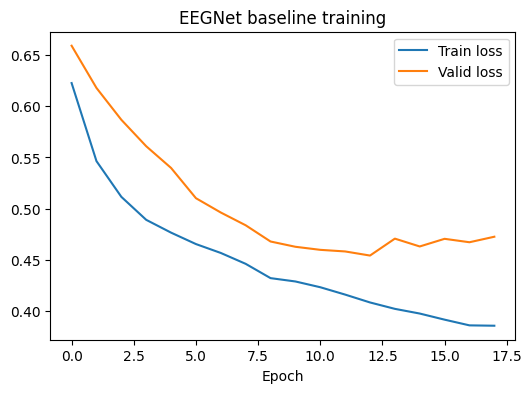

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6059       0.7447        0.6638  0.0005  1.8089
      2        0.5421       0.7574        0.6331  0.0005  1.8082
      3        0.5269       0.7745        0.6059  0.0005  1.8572
      4        0.5008       0.7702        0.5763  0.0005  1.8000
      5        0.4900       0.7830        0.5583  0.0005  1.8127
      6        0.4821       0.7617        0.5323  0.0005  1.7958
      7        0.4620       0.7447        0.5207  0.0005  1.8190
      8        0.4490       0.7574        0.4959  0.0005  1.8071
      9        0.4375       0.7574        0.4928  0.0005  1.9129
     10        0.4315       0.7362        0.4816  0.0005  1.8018
     11        0.4081       0.7404        0.4830  0.0005  1.8523
     12        0.4061       0.7447        0.4876  0.0005  1.8097
     13        0.3985       0.7447        0.4850  0.0005  1.8123
     14        0.3994    

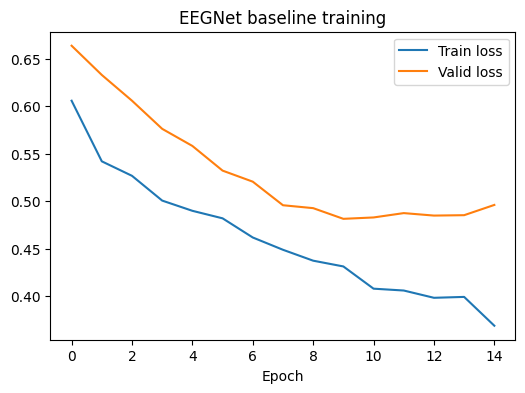

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6237       0.6851        0.6707  0.0005  1.7748
      2        0.5242       0.7064        0.6379  0.0005  1.7939
      3        0.5039       0.7191        0.6150  0.0005  1.7812
      4        0.4935       0.7149        0.5965  0.0005  1.7829
      5        0.4849       0.7234        0.5701  0.0005  1.8278
      6        0.4687       0.7532        0.5582  0.0005  1.7821
      7        0.4683       0.7319        0.5373  0.0005  1.7742
      8        0.4547       0.7404        0.5347  0.0005  1.7797
      9        0.4480       0.7277        0.5230  0.0005  1.7787
     10        0.4427       0.7447        0.5206  0.0005  1.8046
     11        0.4318       0.7319        0.5212  0.0005  1.7756
     12        0.4196       0.7319        0.5181  0.0005  1.7834
     13        0.4210       0.7532        0.5238  0.0005  1.8115
     14        0.4124    

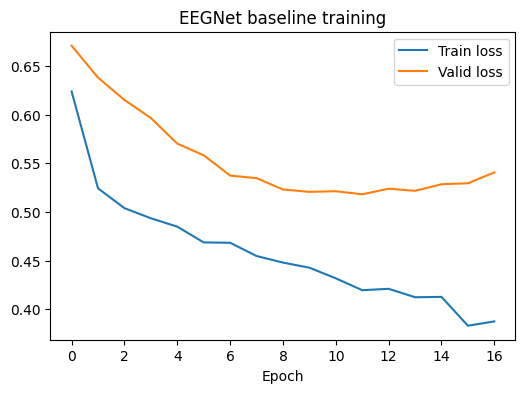

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6212       0.7106        0.6741  0.0005  1.8159
      2        0.5509       0.6979        0.6502  0.0005  1.7894
      3        0.5270       0.6936        0.6271  0.0005  1.7694
      4        0.5160       0.7319        0.6073  0.0005  1.8159
      5        0.5084       0.7489        0.5922  0.0005  1.7876
      6        0.4983       0.7489        0.5748  0.0005  1.7819
      7        0.4975       0.7404        0.5588  0.0005  1.7862
      8        0.4758       0.7277        0.5480  0.0005  1.7740
      9        0.4587       0.7106        0.5423  0.0005  1.7951
     10        0.4569       0.6979        0.5351  0.0005  1.8438
     11        0.4494       0.6979        0.5344  0.0005  1.7880
     12        0.4504       0.7149        0.5286  0.0005  1.7902
     13        0.4382       0.6936        0.5375  0.0005  1.7878
     14        0.4272    

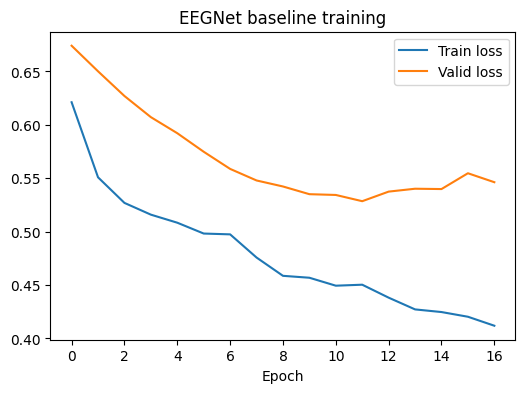

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6771       0.6809        0.6838  0.0005  1.7777
      2        0.5921       0.6979        0.6601  0.0005  1.7899
      3        0.5572       0.6979        0.6397  0.0005  1.7950
      4        0.5329       0.7277        0.6190  0.0005  1.8450
      5        0.5206       0.7277        0.6041  0.0005  1.7822
      6        0.5065       0.7191        0.5831  0.0005  1.7927
      7        0.4961       0.7191        0.5751  0.0005  1.8670
      8        0.4840       0.7277        0.5613  0.0005  1.8397
      9        0.4744       0.7532        0.5512  0.0005  1.8877
     10        0.4642       0.7149        0.5525  0.0005  1.8644
     11        0.4545       0.7106        0.5447  0.0005  1.8959
     12        0.4493       0.7234        0.5489  0.0005  1.8789
     13        0.4406       0.7277        0.5453  0.0005  1.9150
     14        0.4265    

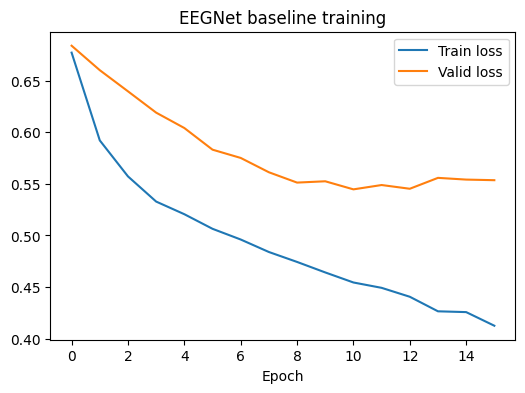

EEGNet + per-trial z-score     acc 0.735±0.040 | κ 0.470±0.079


In [11]:
baseline_acc_ztrial = eval_with_preproc(X, y, subjects, 
                                        build_module=lambda: make_eegnet(),
                                        preproc_pair_fn=zscore_per_trial_pair, 
                                        n_splits=5,
                                        plot_curves=True,)
summarize(baseline_acc_ztrial, "EEGNet + per-trial z-score")


In [12]:
baseline_acc_ztrial

[{'fold': 0, 'acc': 0.6768707482993197, 'kappa': 0.3537414965986394},
 {'fold': 1, 'acc': 0.7064846416382252, 'kappa': 0.413618169971144},
 {'fold': 2, 'acc': 0.7474402730375427, 'kappa': 0.4924863068208417},
 {'fold': 3, 'acc': 0.7542662116040956, 'kappa': 0.5085953878406708},
 {'fold': 4, 'acc': 0.7918088737201365, 'kappa': 0.5834673378545293}]

In [13]:
# baseline_acc_foldstd = eval_with_preproc(X, y, subjects, build_module=lambda: make_eegnet(),
#                                  preproc_pair_fn=foldwise_channel_standardize_pair, n_splits=5)
# summarize(baseline_acc_foldstd, "EEGNet + foldwise channel z-score")


### fine hyperparameter tuning

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6517       0.7021        0.6788  0.0005  1.9107
      2        0.5532       0.7191        0.6421  0.0005  1.9508
      3        0.5086       0.7617        0.6005  0.0005  1.9030
      4        0.4948       0.7447        0.5762  0.0005  1.8205
      5        0.4809       0.7532        0.5506  0.0005  1.8963
      6        0.4672       0.7532        0.5251  0.0005  1.8608
      7        0.4581       0.7532        0.5051  0.0005  1.8324
      8        0.4482       0.7489        0.4892  0.0005  1.8538
      9        0.4357       0.7447        0.4788  0.0005  2.0332
     10        0.4296       0.7489        0.4783  0.0005  1.9129
     11        0.4246       0.7489        0.4705  0.0005  1.9075
     12        0.4159       0.7404        0.4740  0.0005  1.8575
     13        0.4194       0.7787        0.4702  0.0005  1.9257
     14        0.4068    

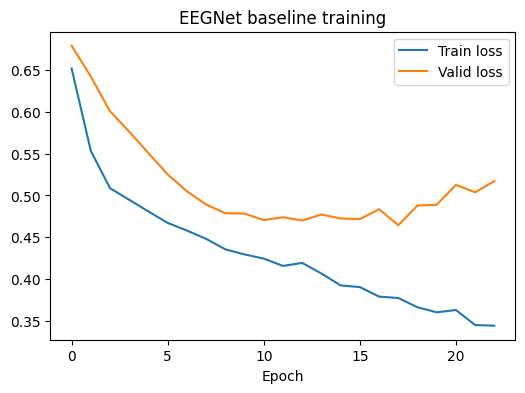

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6591       0.6383        0.6833  0.0005  1.8760
      2        0.5694       0.7277        0.6533  0.0005  1.8596
      3        0.5226       0.7277        0.6222  0.0005  1.9207
      4        0.4906       0.7362        0.5913  0.0005  1.8912
      5        0.4887       0.7489        0.5702  0.0005  1.8526
      6        0.4745       0.7489        0.5524  0.0005  1.8824
      7        0.4548       0.7532        0.5311  0.0005  1.8486
      8        0.4628       0.7617        0.5129  0.0005  1.8805
      9        0.4386       0.7447        0.5037  0.0005  1.9060
     10        0.4259       0.7617        0.4949  0.0005  1.8356
     11        0.4228       0.7447        0.4912  0.0005  1.8547
     12        0.4185       0.7489        0.4887  0.0005  1.9802
     13        0.4134       0.7404        0.4846  0.0005  1.8791
     14        0.3976    

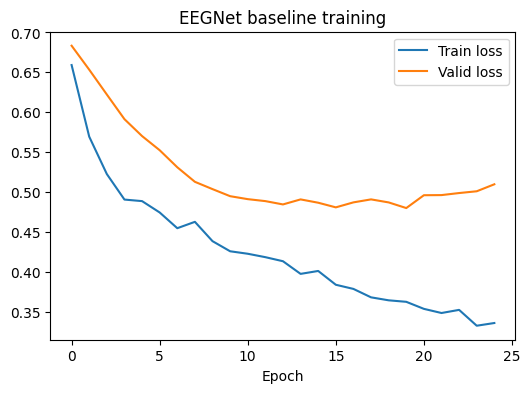

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6453       0.6894        0.6792  0.0005  1.9458
      2        0.5561       0.7234        0.6521  0.0005  1.8809
      3        0.5124       0.7404        0.6231  0.0005  1.8714
      4        0.4928       0.7362        0.6013  0.0005  1.8813
      5        0.4801       0.7404        0.5801  0.0005  1.8378
      6        0.4758       0.7319        0.5676  0.0005  1.9293
      7        0.4612       0.7362        0.5497  0.0005  2.0229
      8        0.4555       0.7319        0.5389  0.0005  2.0486
      9        0.4421       0.7362        0.5323  0.0005  1.9705
     10        0.4419       0.7106        0.5283  0.0005  1.9334
     11        0.4388       0.7277        0.5290  0.0005  1.9310
     12        0.4330       0.7149        0.5178  0.0005  1.9091
     13        0.4168       0.7106        0.5228  0.0005  1.8615
     14        0.4152    

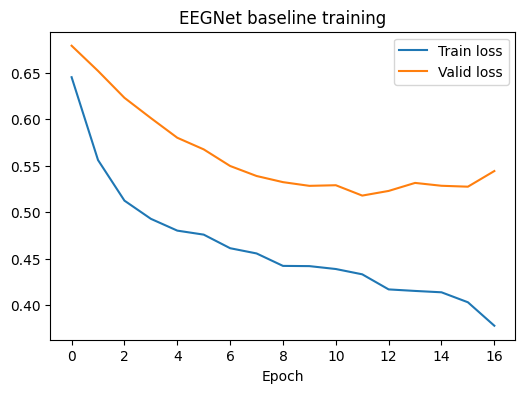

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6773       0.5915        0.6862  0.0005  1.8520
      2        0.5815       0.6426        0.6649  0.0005  1.9592
      3        0.5302       0.6809        0.6366  0.0005  1.8595
      4        0.5086       0.6936        0.6149  0.0005  1.9088
      5        0.4976       0.6936        0.5950  0.0005  1.8580
      6        0.4887       0.6894        0.5825  0.0005  1.9495
      7        0.4886       0.6936        0.5637  0.0005  1.9140
      8        0.4783       0.7021        0.5548  0.0005  1.9364
      9        0.4688       0.7064        0.5458  0.0005  1.8358
     10        0.4621       0.7106        0.5395  0.0005  1.9874
     11        0.4652       0.7106        0.5358  0.0005  1.8987
     12        0.4577       0.7106        0.5344  0.0005  1.8397
     13        0.4451       0.7277        0.5327  0.0005  1.9334
     14        0.4413    

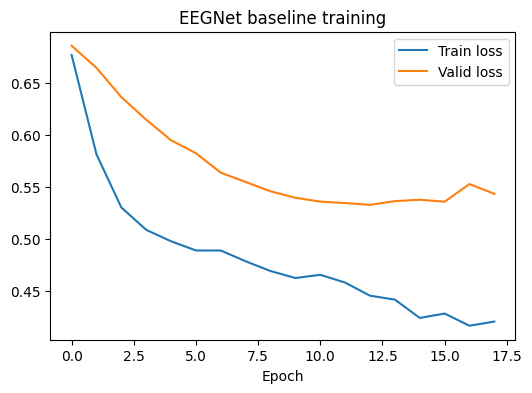

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6251       0.7447        0.6718  0.0005  1.9884
      2        0.5589       0.7447        0.6484  0.0005  1.9340
      3        0.5253       0.7447        0.6260  0.0005  1.9623
      4        0.5096       0.7319        0.6062  0.0005  1.8734
      5        0.4938       0.7191        0.5896  0.0005  1.8234
      6        0.4786       0.7447        0.5705  0.0005  1.9448
      7        0.4775       0.7362        0.5578  0.0005  1.8064
      8        0.4731       0.7447        0.5457  0.0005  1.9089
      9        0.4554       0.7064        0.5504  0.0005  1.9083
     10        0.4563       0.7149        0.5434  0.0005  1.8334
     11        0.4509       0.7362        0.5343  0.0005  1.8632
     12        0.4434       0.7191        0.5391  0.0005  1.8751
     13        0.4367       0.7149        0.5439  0.0005  1.7800
     14        0.4223    

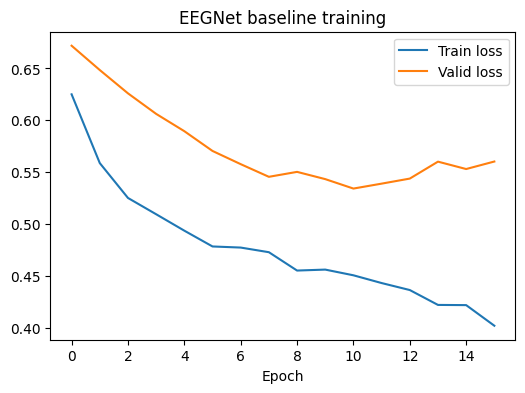

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6768       0.6766        0.6831  0.0005  1.8799
      2        0.6072       0.7660        0.6553  0.0005  1.8454
      3        0.5658       0.7745        0.6158  0.0005  1.8289
      4        0.5205       0.7830        0.5803  0.0005  1.9892
      5        0.5049       0.7787        0.5536  0.0005  1.9052
      6        0.4918       0.7787        0.5297  0.0005  1.9792
      7        0.4704       0.7745        0.5044  0.0005  1.9236
      8        0.4707       0.7745        0.4897  0.0005  1.9466
      9        0.4575       0.7532        0.4771  0.0005  1.8697
     10        0.4598       0.7489        0.4744  0.0005  2.0505
     11        0.4357       0.7574        0.4724  0.0005  1.9979
     12        0.4452       0.7745        0.4604  0.0005  1.9035
     13        0.4358       0.7574        0.4628  0.0005  1.9927
     14        0.4118    

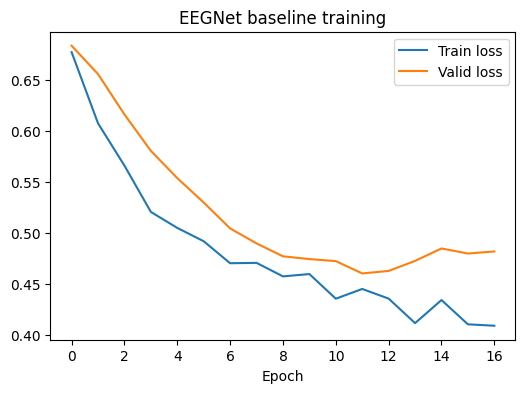

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6834       0.6511        0.6830  0.0005  1.9368
      2        0.6109       0.7191        0.6548  0.0005  1.8595
      3        0.5733       0.7404        0.6141  0.0005  1.9036
      4        0.5340       0.7702        0.5779  0.0005  1.8682
      5        0.5191       0.7702        0.5515  0.0005  1.9111
      6        0.5109       0.7702        0.5265  0.0005  1.9482
      7        0.5002       0.7787        0.5134  0.0005  1.9215
      8        0.4736       0.7830        0.4961  0.0005  1.8520
      9        0.4804       0.7830        0.4867  0.0005  1.8689
     10        0.4803       0.7872        0.4846  0.0005  1.8515
     11        0.4522       0.7915        0.4794  0.0005  1.9159
     12        0.4525       0.7660        0.4803  0.0005  1.8550
     13        0.4610       0.7617        0.4806  0.0005  1.8876
     14        0.4281    

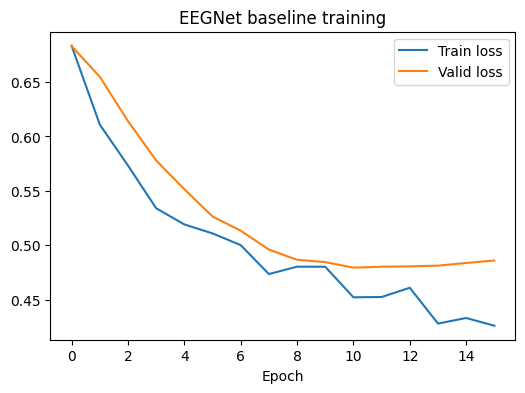

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6629       0.6596        0.6779  0.0005  1.9073
      2        0.5776       0.6979        0.6474  0.0005  1.9768
      3        0.5462       0.7191        0.6130  0.0005  1.8929
      4        0.5250       0.7234        0.5878  0.0005  1.8717
      5        0.5029       0.7064        0.5718  0.0005  1.8426
      6        0.5037       0.7362        0.5544  0.0005  1.8982
      7        0.4995       0.7362        0.5412  0.0005  1.9006
      8        0.5073       0.7447        0.5340  0.0005  1.9307
      9        0.4855       0.7489        0.5259  0.0005  2.0384
     10        0.4849       0.7532        0.5217  0.0005  1.9460
     11        0.4743       0.7362        0.5182  0.0005  1.9695
     12        0.4630       0.7362        0.5181  0.0005  2.0130
     13        0.4735       0.7489        0.5141  0.0005  1.9722
     14        0.4552    

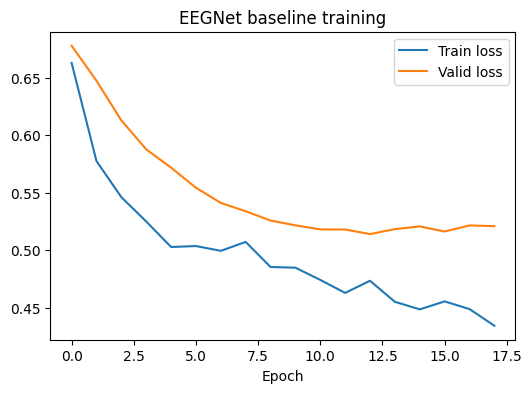

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7076       0.5447        0.6892  0.0005  2.0352
      2        0.6138       0.6553        0.6689  0.0005  1.8692
      3        0.5697       0.6596        0.6358  0.0005  1.8849
      4        0.5521       0.6596        0.6131  0.0005  1.9252
      5        0.5298       0.6638        0.5937  0.0005  1.9266
      6        0.5266       0.6894        0.5781  0.0005  1.9686
      7        0.5186       0.6979        0.5667  0.0005  1.8788
      8        0.5076       0.7149        0.5524  0.0005  2.0295
      9        0.4991       0.7106        0.5428  0.0005  1.8416
     10        0.5039       0.7234        0.5405  0.0005  2.0610
     11        0.4856       0.7106        0.5378  0.0005  2.1465
     12        0.4832       0.7106        0.5361  0.0005  1.9797
     13        0.4694       0.7106        0.5330  0.0005  1.8619
     14        0.4735    

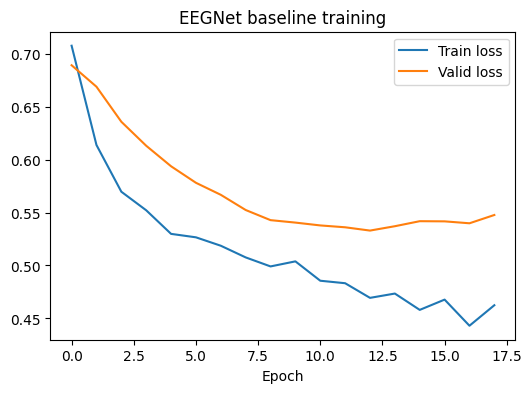

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6716       0.7319        0.6740  0.0005  1.9575
      2        0.6031       0.7277        0.6459  0.0005  1.9213
      3        0.5665       0.7404        0.6135  0.0005  1.9583
      4        0.5636       0.7489        0.5907  0.0005  1.9202
      5        0.5265       0.7489        0.5752  0.0005  1.8790
      6        0.5262       0.7489        0.5602  0.0005  1.9120
      7        0.5017       0.7447        0.5522  0.0005  1.8817
      8        0.4935       0.7404        0.5374  0.0005  1.9786
      9        0.4999       0.7532        0.5384  0.0005  1.8014
     10        0.4823       0.7362        0.5258  0.0005  1.9145
     11        0.4771       0.7191        0.5304  0.0005  1.8901
     12        0.4844       0.7191        0.5254  0.0005  1.9459
     13        0.4602       0.7191        0.5283  0.0005  1.8216
     14        0.4637    

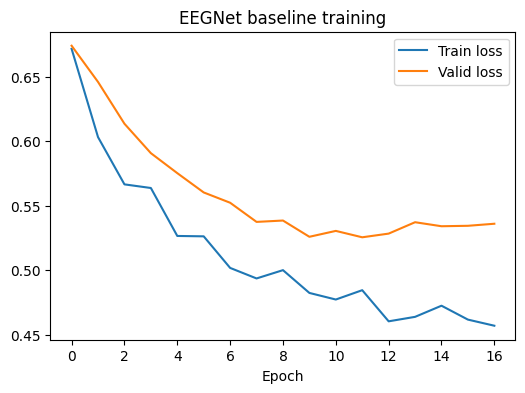

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6146       0.7702        0.6699  0.0005  2.8673
      2        0.5228       0.7617        0.6379  0.0005  2.7938
      3        0.4874       0.7532        0.6161  0.0005  2.7597
      4        0.4699       0.7617        0.5912  0.0005  2.7487
      5        0.4561       0.7745        0.5607  0.0005  2.7404
      6        0.4389       0.7489        0.5282  0.0005  2.8198
      7        0.4308       0.7617        0.4954  0.0005  2.7179
      8        0.4218       0.7362        0.4834  0.0005  2.8782
      9        0.3955       0.7660        0.4668  0.0005  2.7306
     10        0.3933       0.7660        0.4540  0.0005  2.8536
     11        0.3774       0.7404        0.4596  0.0005  2.8799
     12        0.3713       0.7660        0.4647  0.0005  2.8457
     13        0.3576       0.7489        0.4657  0.0005  2.9082
     14        0.3470    

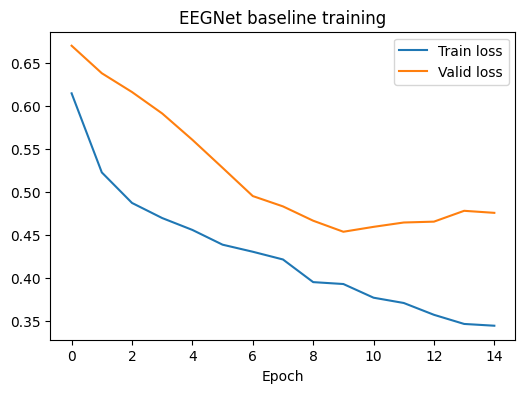

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6016       0.7489        0.6676  0.0005  3.0469
      2        0.5133       0.7574        0.6495  0.0005  3.0950
      3        0.4874       0.7617        0.6283  0.0005  2.9230
      4        0.4767       0.7787        0.6090  0.0005  3.1367
      5        0.4487       0.7915        0.5809  0.0005  2.9369
      6        0.4315       0.7915        0.5553  0.0005  3.0614
      7        0.4215       0.7702        0.5280  0.0005  3.0119
      8        0.4060       0.7830        0.5116  0.0005  3.1383
      9        0.3977       0.7872        0.4931  0.0005  3.1204
     10        0.3869       0.7745        0.4867  0.0005  3.1026
     11        0.3776       0.7660        0.4867  0.0005  2.9257
     12        0.3631       0.7660        0.4873  0.0005  2.9755
     13        0.3521       0.7617        0.4895  0.0005  2.9752
     14        0.3424    

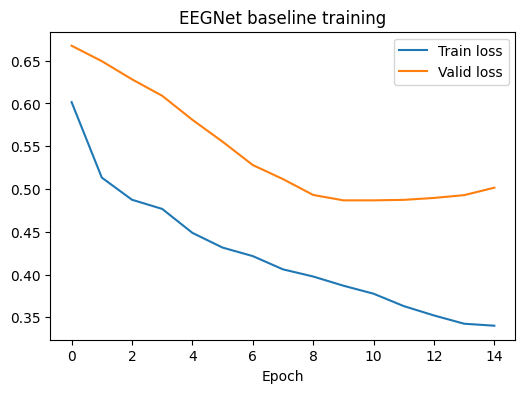

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5941       0.6979        0.6707  0.0005  2.9702
      2        0.5064       0.7064        0.6474  0.0005  3.0027
      3        0.4846       0.7191        0.6320  0.0005  2.9765
      4        0.4703       0.7447        0.6170  0.0005  3.1081
      5        0.4509       0.7362        0.5939  0.0005  2.9941
      6        0.4432       0.7234        0.5749  0.0005  2.9140
      7        0.4330       0.7447        0.5555  0.0005  2.9388
      8        0.4106       0.7447        0.5442  0.0005  2.9275
      9        0.4100       0.7447        0.5377  0.0005  2.8742
     10        0.3885       0.7191        0.5306  0.0005  2.8754
     11        0.3849       0.7447        0.5238  0.0005  2.8949
     12        0.3676       0.7447        0.5294  0.0005  2.9116
     13        0.3589       0.7404        0.5416  0.0005  2.9756
     14        0.3456    

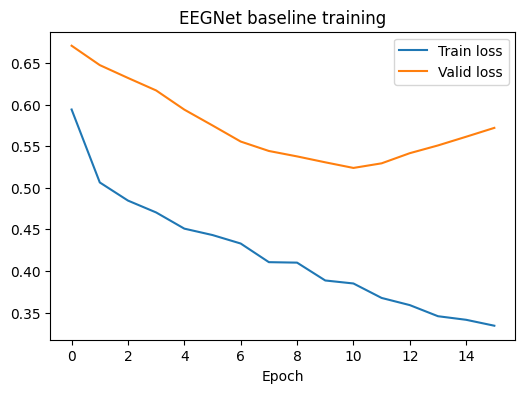

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6286       0.6681        0.6765  0.0005  2.9354
      2        0.5318       0.6936        0.6544  0.0005  3.0628
      3        0.5130       0.6809        0.6451  0.0005  2.9710
      4        0.4924       0.6936        0.6254  0.0005  2.9561
      5        0.4688       0.6894        0.6048  0.0005  3.1164
      6        0.4533       0.7191        0.5849  0.0005  3.0165
      7        0.4445       0.7234        0.5683  0.0005  3.0687
      8        0.4292       0.7064        0.5567  0.0005  2.9645
      9        0.4226       0.7277        0.5439  0.0005  3.0644
     10        0.4096       0.7106        0.5374  0.0005  3.0075
     11        0.4051       0.7191        0.5515  0.0005  3.0101
     12        0.3905       0.6894        0.5466  0.0005  2.9393
     13        0.3889       0.6936        0.5594  0.0005  2.9192
     14        0.3797    

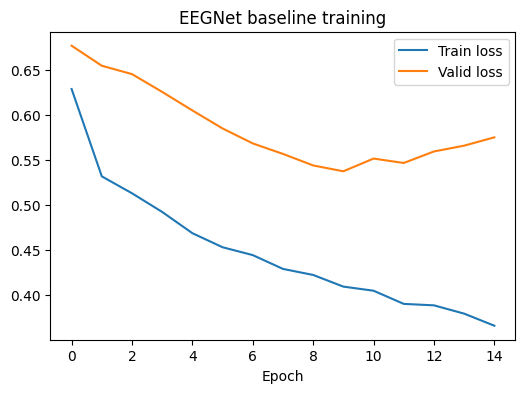

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6512       0.7319        0.6782  0.0005  2.8879
      2        0.5484       0.7404        0.6563  0.0005  2.9619
      3        0.5218       0.7489        0.6391  0.0005  2.9484
      4        0.4930       0.7362        0.6200  0.0005  2.9615
      5        0.4749       0.7362        0.6016  0.0005  2.9622
      6        0.4636       0.7234        0.5862  0.0005  2.8877
      7        0.4539       0.7319        0.5702  0.0005  2.9096
      8        0.4408       0.7277        0.5488  0.0005  2.9389
      9        0.4359       0.7149        0.5451  0.0005  2.8762
     10        0.4215       0.7149        0.5402  0.0005  2.9970
     11        0.4006       0.7106        0.5373  0.0005  3.0804
     12        0.4012       0.7149        0.5377  0.0005  2.9599
     13        0.3821       0.7149        0.5448  0.0005  3.0398
     14        0.3657    

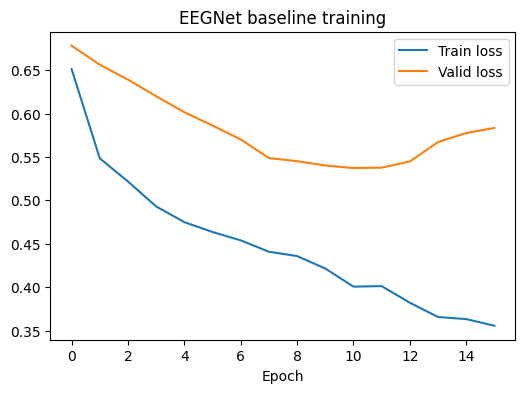

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6333       0.7489        0.6654  0.0005  3.0182
      2        0.5479       0.7830        0.6344  0.0005  2.8947
      3        0.5091       0.7872        0.6057  0.0005  2.9697
      4        0.4963       0.7787        0.5821  0.0005  2.9263
      5        0.4737       0.7617        0.5419  0.0005  3.0124
      6        0.4670       0.7574        0.5275  0.0005  2.9700
      7        0.4586       0.7532        0.5015  0.0005  3.0859
      8        0.4574       0.7660        0.4789  0.0005  3.0394
      9        0.4377       0.7532        0.4657  0.0005  3.1213
     10        0.4417       0.7532        0.4542  0.0005  3.0271
     11        0.4289       0.7489        0.4452  0.0005  3.0291
     12        0.4124       0.7617        0.4399  0.0005  3.0143
     13        0.4110       0.7532        0.4427  0.0005  3.0181
     14        0.4084    

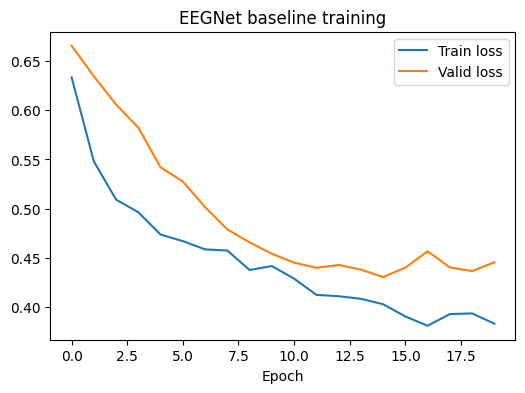

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6352       0.6766        0.6718  0.0005  2.9385
      2        0.5330       0.7362        0.6435  0.0005  3.0174
      3        0.5036       0.7404        0.6155  0.0005  3.0727
      4        0.4860       0.7319        0.5875  0.0005  2.9739
      5        0.4674       0.7532        0.5586  0.0005  3.0763
      6        0.4579       0.7702        0.5375  0.0005  2.8795
      7        0.4445       0.7745        0.5172  0.0005  2.8898
      8        0.4288       0.7617        0.5006  0.0005  2.8794
      9        0.4254       0.7617        0.4830  0.0005  2.8761
     10        0.4186       0.7532        0.4742  0.0005  2.9892
     11        0.4115       0.7617        0.4697  0.0005  2.9050
     12        0.4148       0.7532        0.4660  0.0005  2.8635
     13        0.3941       0.7617        0.4666  0.0005  2.8944
     14        0.3820    

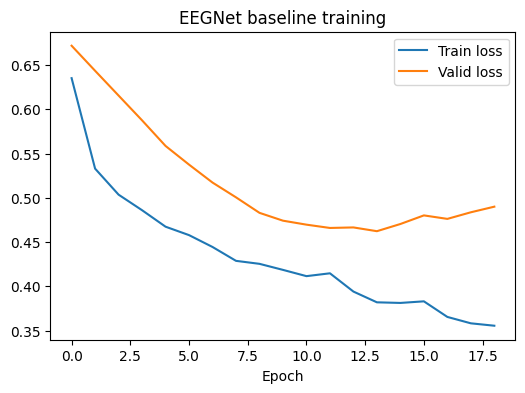

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6471       0.6681        0.6804  0.0005  2.9775
      2        0.5525       0.7106        0.6527  0.0005  2.9132
      3        0.5097       0.7447        0.6249  0.0005  2.8873
      4        0.5059       0.7234        0.6031  0.0005  2.9308
      5        0.4863       0.7489        0.5816  0.0005  2.9070
      6        0.4747       0.7404        0.5612  0.0005  2.9720
      7        0.4531       0.7574        0.5380  0.0005  2.9592
      8        0.4552       0.7489        0.5289  0.0005  2.9011
      9        0.4423       0.7447        0.5105  0.0005  2.8742
     10        0.4373       0.7660        0.5071  0.0005  2.9917
     11        0.4233       0.7660        0.5026  0.0005  2.9262
     12        0.4252       0.7362        0.5013  0.0005  2.9487
     13        0.4252       0.7447        0.5116  0.0005  2.9289
     14        0.4085    

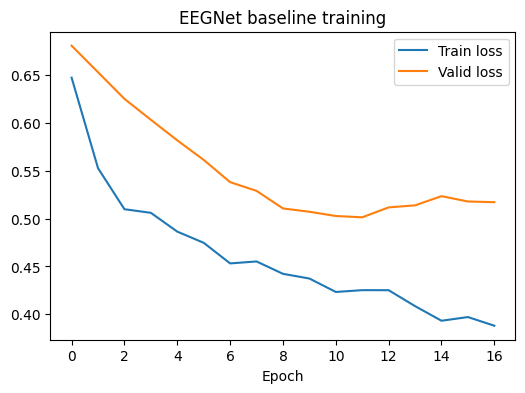

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6689       0.6426        0.6851  0.0005  2.8957
      2        0.5663       0.6766        0.6565  0.0005  2.9542
      3        0.5293       0.6894        0.6346  0.0005  2.9284
      4        0.5096       0.7064        0.6178  0.0005  2.8933
      5        0.5228       0.7234        0.6012  0.0005  2.9144
      6        0.4940       0.7064        0.5842  0.0005  2.8789
      7        0.4815       0.7149        0.5650  0.0005  2.9521
      8        0.4666       0.7149        0.5529  0.0005  2.8816
      9        0.4721       0.7064        0.5406  0.0005  2.9998
     10        0.4641       0.7319        0.5410  0.0005  3.0691
     11        0.4494       0.7277        0.5418  0.0005  2.9149
     12        0.4362       0.7447        0.5361  0.0005  2.9205
     13        0.4377       0.7106        0.5465  0.0005  2.8949
     14        0.4314    

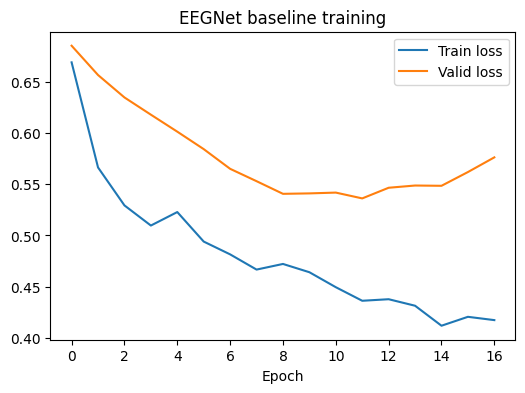

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6650       0.7106        0.6760  0.0005  2.9294
      2        0.5647       0.7277        0.6516  0.0005  2.8810
      3        0.5403       0.7106        0.6297  0.0005  2.8781
      4        0.5200       0.7149        0.6208  0.0005  2.9633
      5        0.5075       0.7234        0.5944  0.0005  2.9226
      6        0.5121       0.7064        0.5834  0.0005  2.8714
      7        0.4844       0.6979        0.5808  0.0005  2.8694
      8        0.4819       0.7021        0.5761  0.0005  2.9566
      9        0.4673       0.6979        0.5650  0.0005  2.9343
     10        0.4723       0.6851        0.5696  0.0005  2.9031
     11        0.4612       0.6851        0.5679  0.0005  2.9259
     12        0.4508       0.6851        0.5660  0.0005  2.8824
     13        0.4576       0.6851        0.5711  0.0005  2.8749
Stopping since valid_loss

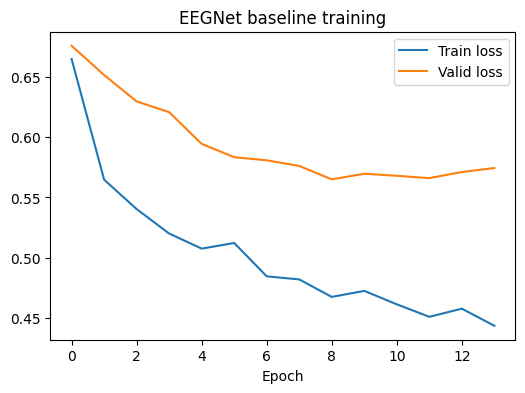

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6261       0.7149        0.6634  0.0005  3.3423
      2        0.5273       0.7617        0.6228  0.0005  3.3356
      3        0.4930       0.7702        0.5973  0.0005  3.3658
      4        0.4560       0.7787        0.5668  0.0005  3.4065
      5        0.4404       0.7745        0.5377  0.0005  3.3875
      6        0.4424       0.7660        0.5085  0.0005  3.4562
      7        0.4211       0.7745        0.4860  0.0005  3.5331
      8        0.4209       0.7872        0.4694  0.0005  3.3261
      9        0.3989       0.7787        0.4558  0.0005  3.4106
     10        0.3926       0.7830        0.4439  0.0005  3.4280
     11        0.3717       0.7872        0.4555  0.0005  3.3592
     12        0.3573       0.7574        0.4544  0.0005  3.4096
     13        0.3471       0.7915        0.4460  0.0005  3.4473
     14        0.3345    

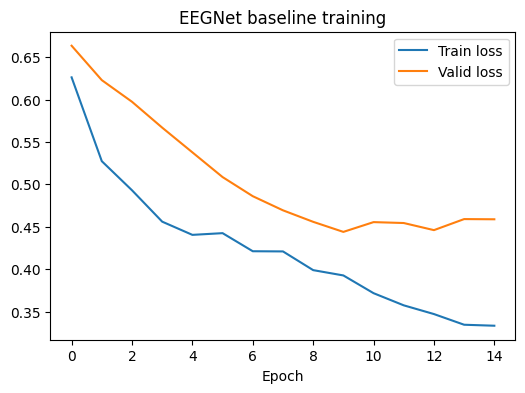

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6007       0.7191        0.6680  0.0005  3.3373
      2        0.5207       0.7277        0.6465  0.0005  3.5222
      3        0.4929       0.7404        0.6287  0.0005  3.3985
      4        0.4729       0.7532        0.6004  0.0005  3.4119
      5        0.4577       0.7745        0.5811  0.0005  3.3485
      6        0.4431       0.7362        0.5539  0.0005  3.4158
      7        0.4192       0.7702        0.5239  0.0005  3.4112
      8        0.4233       0.7660        0.5036  0.0005  3.4301
      9        0.4033       0.7617        0.4897  0.0005  3.3624
     10        0.3925       0.7362        0.4856  0.0005  3.3755
     11        0.3784       0.7745        0.4732  0.0005  3.3551
     12        0.3683       0.7362        0.4822  0.0005  3.1887
     13        0.3600       0.7362        0.4861  0.0005  3.1769
     14        0.3480    

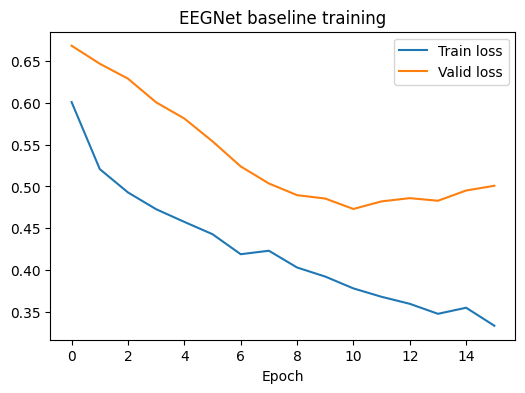

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6062       0.6723        0.6726  0.0005  3.3768
      2        0.5041       0.7064        0.6487  0.0005  3.3826
      3        0.4763       0.7149        0.6328  0.0005  3.4136
      4        0.4621       0.7362        0.6176  0.0005  3.3730
      5        0.4338       0.7277        0.5942  0.0005  3.4260
      6        0.4246       0.7532        0.5746  0.0005  3.3751
      7        0.4036       0.7532        0.5570  0.0005  3.4169
      8        0.3892       0.7787        0.5428  0.0005  3.3856
      9        0.3772       0.7574        0.5327  0.0005  3.3766
     10        0.3672       0.7404        0.5310  0.0005  3.4293
     11        0.3606       0.7574        0.5344  0.0005  3.4395
     12        0.3450       0.7489        0.5353  0.0005  3.3654
     13        0.3518       0.7447        0.5489  0.0005  3.3754
     14        0.3342    

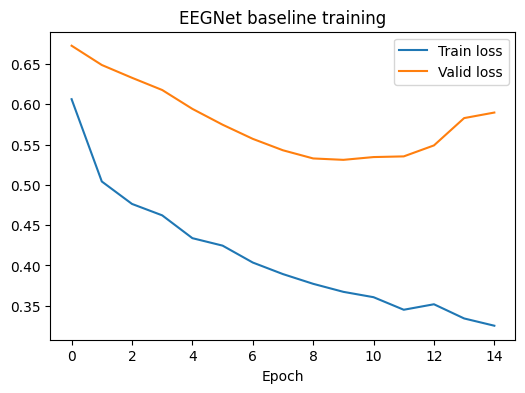

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6179       0.6809        0.6751  0.0005  3.5017
      2        0.5315       0.6894        0.6552  0.0005  3.5736
      3        0.5084       0.7191        0.6389  0.0005  3.4659
      4        0.4876       0.7489        0.6187  0.0005  3.3008
      5        0.4722       0.7319        0.6029  0.0005  3.5118
      6        0.4608       0.7362        0.5781  0.0005  3.3826
      7        0.4479       0.7319        0.5572  0.0005  3.3366
      8        0.4380       0.7277        0.5424  0.0005  3.3087
      9        0.4145       0.7234        0.5393  0.0005  3.4460
     10        0.4140       0.7277        0.5319  0.0005  3.5217
     11        0.4089       0.7149        0.5322  0.0005  3.4200
     12        0.3851       0.7362        0.5262  0.0005  3.4838
     13        0.3820       0.7191        0.5259  0.0005  3.4097
     14        0.3679    

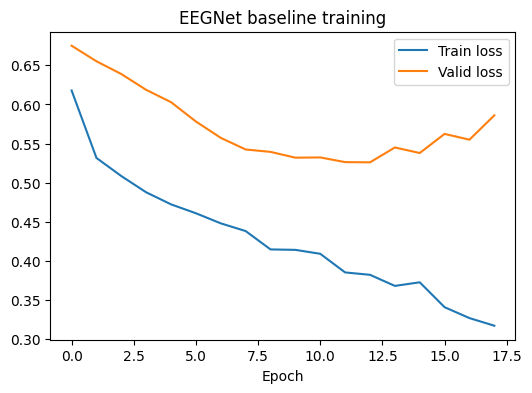

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6459       0.7021        0.6755  0.0005  3.4773
      2        0.5486       0.7191        0.6582  0.0005  3.3607
      3        0.5189       0.7234        0.6457  0.0005  3.3471
      4        0.5039       0.7191        0.6302  0.0005  3.4001
      5        0.4788       0.7149        0.6157  0.0005  3.5261
      6        0.4757       0.6936        0.5946  0.0005  3.4204
      7        0.4641       0.7064        0.5802  0.0005  3.3493
      8        0.4475       0.7064        0.5677  0.0005  3.3787
      9        0.4501       0.6894        0.5730  0.0005  3.3448
     10        0.4359       0.7021        0.5567  0.0005  3.2500
     11        0.4211       0.6809        0.5545  0.0005  3.3724
     12        0.4178       0.6894        0.5605  0.0005  3.3931
     13        0.3975       0.6894        0.5613  0.0005  3.3552
     14        0.3936    

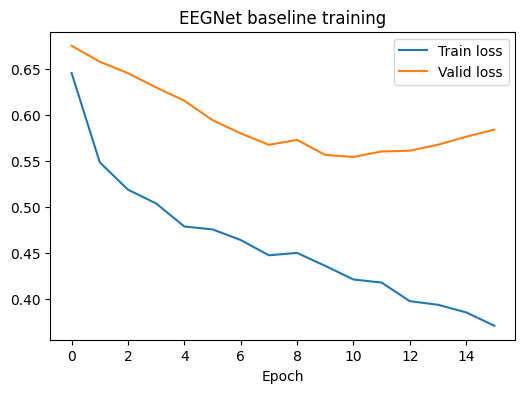

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6251       0.7660        0.6691  0.0005  3.3551
      2        0.5350       0.7872        0.6304  0.0005  3.4116
      3        0.5042       0.7787        0.6045  0.0005  3.4366
      4        0.4861       0.7702        0.5679  0.0005  3.4094
      5        0.4708       0.7660        0.5492  0.0005  3.3478
      6        0.4477       0.7660        0.5183  0.0005  3.4747
      7        0.4682       0.7532        0.4944  0.0005  3.3891
      8        0.4439       0.7702        0.4731  0.0005  3.3980
      9        0.4608       0.7532        0.4684  0.0005  3.3647
     10        0.4355       0.7660        0.4571  0.0005  3.4501
     11        0.4219       0.7532        0.4531  0.0005  3.3715
     12        0.4110       0.7489        0.4554  0.0005  3.3852
     13        0.4114       0.7532        0.4560  0.0005  3.3875
     14        0.4031    

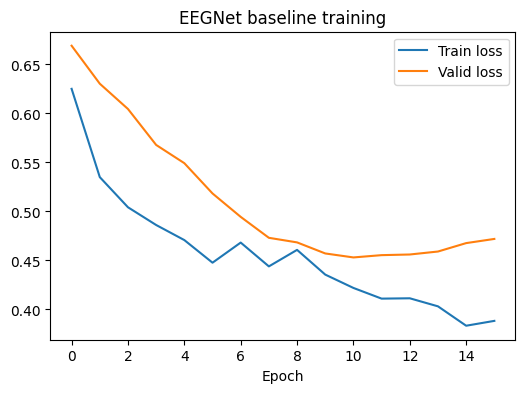

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6328       0.7106        0.6696  0.0005  3.4152
      2        0.5608       0.7362        0.6365  0.0005  3.3869
      3        0.5280       0.7489        0.6072  0.0005  3.4234
      4        0.4895       0.7617        0.5803  0.0005  3.4024
      5        0.4830       0.7574        0.5585  0.0005  3.4618
      6        0.4572       0.7574        0.5343  0.0005  3.3614
      7        0.4552       0.7574        0.5154  0.0005  3.4070
      8        0.4424       0.7660        0.4937  0.0005  3.3159
      9        0.4327       0.7574        0.4799  0.0005  3.3945
     10        0.4271       0.7447        0.4792  0.0005  3.4358
     11        0.4081       0.7617        0.4675  0.0005  3.3812
     12        0.4169       0.7617        0.4635  0.0005  3.3634
     13        0.3994       0.7447        0.4697  0.0005  3.4012
     14        0.3917    

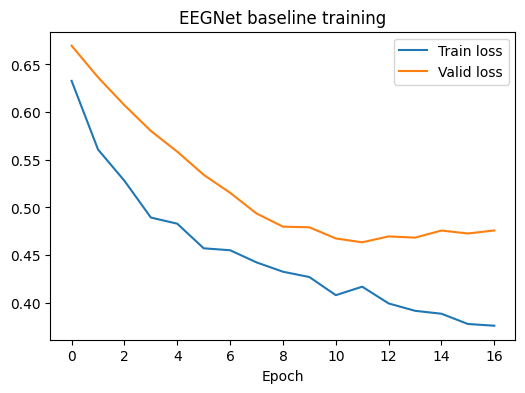

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6575       0.6979        0.6826  0.0005  3.4397
      2        0.5471       0.7021        0.6553  0.0005  3.4006
      3        0.5091       0.7234        0.6308  0.0005  3.4260
      4        0.4833       0.7404        0.6079  0.0005  3.4062
      5        0.4673       0.7404        0.5906  0.0005  3.4351
      6        0.4673       0.7404        0.5681  0.0005  3.4655
      7        0.4469       0.7489        0.5476  0.0005  3.4295
      8        0.4557       0.7447        0.5341  0.0005  3.3604
      9        0.4385       0.7574        0.5304  0.0005  3.3496
     10        0.4244       0.7277        0.5210  0.0005  3.3125
     11        0.4213       0.7319        0.5199  0.0005  3.4782
     12        0.4066       0.7617        0.5338  0.0005  3.3942
     13        0.3973       0.7617        0.5301  0.0005  3.3926
     14        0.4022    

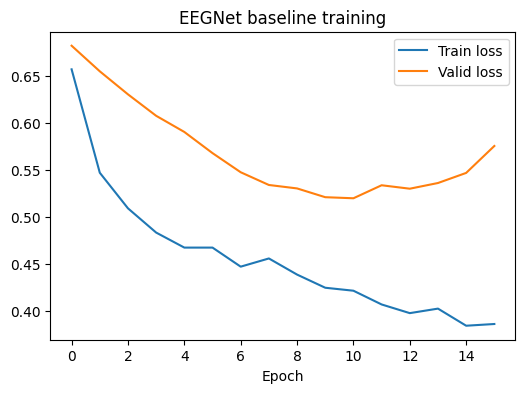

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6436       0.6681        0.6782  0.0005  3.4224
      2        0.5521       0.6809        0.6514  0.0005  3.4395
      3        0.5359       0.6809        0.6280  0.0005  3.3660
      4        0.5194       0.7064        0.6119  0.0005  3.3957
      5        0.5121       0.7106        0.5928  0.0005  3.3372
      6        0.4972       0.7319        0.5761  0.0005  3.4556
      7        0.4850       0.7234        0.5530  0.0005  3.3782
      8        0.4690       0.7362        0.5394  0.0005  3.4527
      9        0.4579       0.7404        0.5274  0.0005  3.4051
     10        0.4558       0.7234        0.5187  0.0005  3.4433
     11        0.4364       0.7191        0.5253  0.0005  3.3844
     12        0.4238       0.7064        0.5334  0.0005  3.3388
     13        0.4245       0.7277        0.5175  0.0005  3.3774
     14        0.4076    

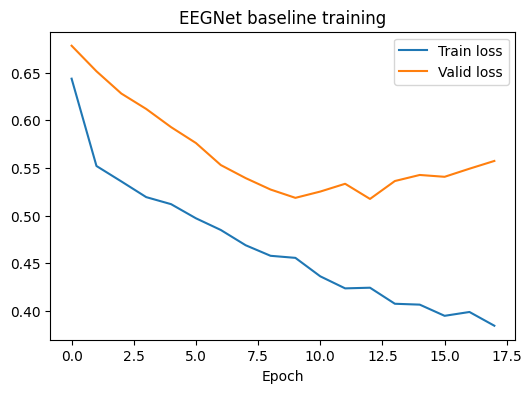

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6746       0.7021        0.6782  0.0005  3.3578
      2        0.5818       0.7319        0.6493  0.0005  3.4516
      3        0.5513       0.7106        0.6290  0.0005  3.4678
      4        0.5418       0.7106        0.6124  0.0005  3.4724
      5        0.5197       0.7106        0.6000  0.0005  3.4243
      6        0.5067       0.7191        0.5831  0.0005  3.4449
      7        0.4973       0.6979        0.5673  0.0005  3.3965
      8        0.4846       0.7064        0.5619  0.0005  3.4814
      9        0.4851       0.6979        0.5586  0.0005  3.4695
     10        0.4930       0.7021        0.5469  0.0005  3.3787
     11        0.4717       0.7021        0.5596  0.0005  3.3631
     12        0.4607       0.6936        0.5535  0.0005  3.4038
     13        0.4569       0.7106        0.5505  0.0005  3.4044
     14        0.4551    

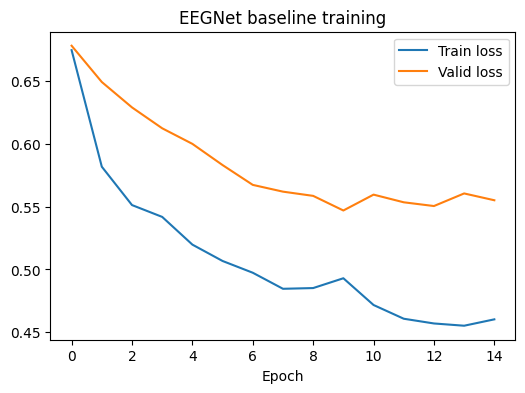

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5914       0.7702        0.6632  0.0005  4.6479
      2        0.4979       0.7702        0.6510  0.0005  4.7480
      3        0.4630       0.7787        0.6288  0.0005  4.7206
      4        0.4354       0.7617        0.6079  0.0005  4.7886
      5        0.4171       0.7660        0.5736  0.0005  4.6849
      6        0.3940       0.7702        0.5430  0.0005  4.7037
      7        0.3721       0.7617        0.5122  0.0005  4.7032
      8        0.3581       0.7574        0.4913  0.0005  4.6817
      9        0.3343       0.7447        0.4796  0.0005  4.6873
     10        0.3189       0.7745        0.4579  0.0005  4.7482
     11        0.2929       0.7532        0.4766  0.0005  4.6988
     12        0.2779       0.7745        0.4908  0.0005  4.7196
     13        0.2801       0.7447        0.4938  0.0005  4.7513
     14        0.2749    

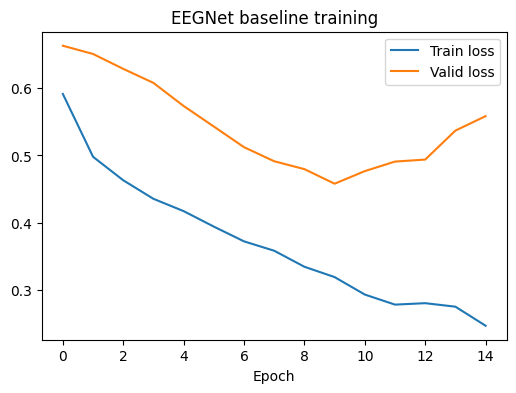

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5721       0.7830        0.6643  0.0005  4.6508
      2        0.4900       0.7830        0.6522  0.0005  4.6934
      3        0.4558       0.7702        0.6279  0.0005  4.6921
      4        0.4302       0.7447        0.5993  0.0005  4.7497
      5        0.4027       0.7660        0.5761  0.0005  4.7148
      6        0.3900       0.7447        0.5488  0.0005  4.6603
      7        0.3823       0.7106        0.5281  0.0005  4.7676
      8        0.3651       0.7447        0.5015  0.0005  4.7977
      9        0.3392       0.7489        0.4861  0.0005  4.7107
     10        0.3279       0.7191        0.4821  0.0005  4.6922
     11        0.3217       0.7404        0.4920  0.0005  4.8059
     12        0.3126       0.7319        0.5052  0.0005  4.9089
     13        0.3039       0.7277        0.4858  0.0005  4.6748
     14        0.2924    

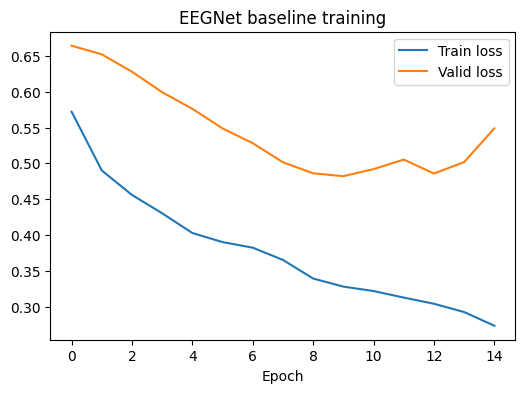

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5771       0.6936        0.6721  0.0005  4.8073
      2        0.4816       0.7234        0.6606  0.0005  4.7266
      3        0.4439       0.7277        0.6459  0.0005  4.6580
      4        0.4282       0.7277        0.6254  0.0005  4.7098
      5        0.4121       0.7319        0.6130  0.0005  4.6924
      6        0.3977       0.7362        0.5974  0.0005  4.6695
      7        0.3855       0.7277        0.5652  0.0005  4.7664
      8        0.3696       0.7319        0.5601  0.0005  4.6876
      9        0.3391       0.7362        0.5519  0.0005  4.6691
     10        0.3326       0.7277        0.5566  0.0005  4.7325
     11        0.3348       0.7447        0.5349  0.0005  4.6824
     12        0.2926       0.7574        0.5568  0.0005  4.7101
     13        0.2855       0.7404        0.5802  0.0005  4.6682
     14        0.2805    

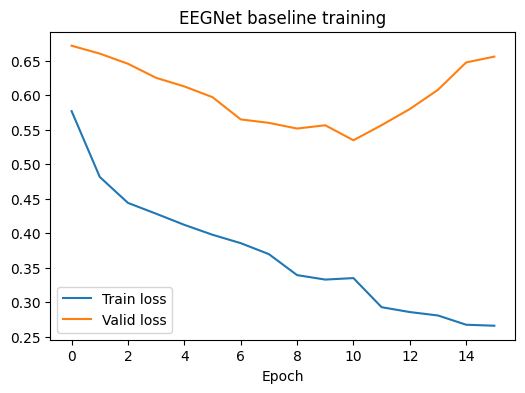

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5805       0.6979        0.6693  0.0005  4.6788
      2        0.4989       0.7234        0.6554  0.0005  4.6742
      3        0.4739       0.7106        0.6386  0.0005  4.6813
      4        0.4560       0.7234        0.6252  0.0005  4.5975
      5        0.4365       0.7319        0.5987  0.0005  4.6824
      6        0.4174       0.7404        0.5840  0.0005  4.7410
      7        0.4010       0.7277        0.5633  0.0005  4.6881
      8        0.3842       0.7319        0.5468  0.0005  4.6887
      9        0.3723       0.7277        0.5311  0.0005  4.7201
     10        0.3438       0.7404        0.5384  0.0005  4.6850
     11        0.3312       0.7234        0.5311  0.0005  4.6693
     12        0.3190       0.7489        0.5418  0.0005  4.7762
     13        0.3171       0.7319        0.5547  0.0005  4.7590
Stopping since valid_loss

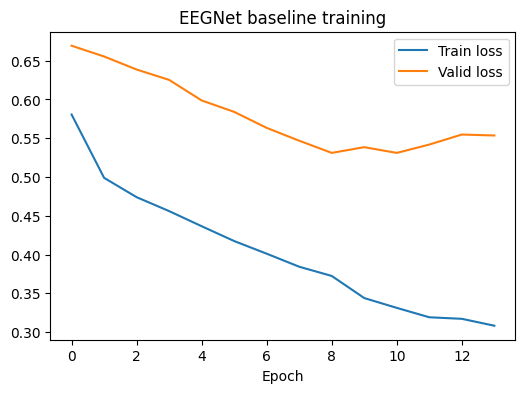

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6069       0.7234        0.6744  0.0005  4.9935
      2        0.5198       0.7234        0.6641  0.0005  4.7656
      3        0.4880       0.6979        0.6556  0.0005  4.7949
      4        0.4668       0.7234        0.6361  0.0005  4.6929
      5        0.4506       0.7149        0.6162  0.0005  4.7258
      6        0.4310       0.7191        0.6014  0.0005  4.7343
      7        0.4094       0.7149        0.5744  0.0005  4.7301
      8        0.4041       0.7149        0.5480  0.0005  4.7053
      9        0.3828       0.7064        0.5382  0.0005  4.7655
     10        0.3682       0.7191        0.5235  0.0005  4.7312
     11        0.3618       0.7021        0.5354  0.0005  4.7082
     12        0.3432       0.7106        0.5412  0.0005  4.9028
     13        0.3354       0.6979        0.5767  0.0005  4.7949
     14        0.3116    

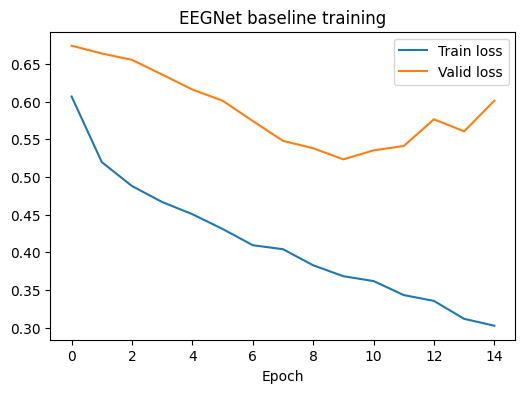

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6189       0.7447        0.6633  0.0005  4.8131
      2        0.5227       0.7574        0.6423  0.0005  4.8443
      3        0.4906       0.7489        0.6204  0.0005  4.7633
      4        0.4649       0.7660        0.5978  0.0005  4.7706
      5        0.4641       0.7660        0.5620  0.0005  4.7135
      6        0.4491       0.7660        0.5230  0.0005  4.8259
      7        0.4193       0.7787        0.4956  0.0005  4.6883
      8        0.4223       0.7617        0.4758  0.0005  4.7184
      9        0.4036       0.7660        0.4574  0.0005  4.9174
     10        0.3976       0.7574        0.4524  0.0005  4.6840
     11        0.3813       0.7702        0.4567  0.0005  4.7055
     12        0.3788       0.7915        0.4501  0.0005  4.7836
     13        0.3610       0.7745        0.4619  0.0005  4.7112
     14        0.3412    

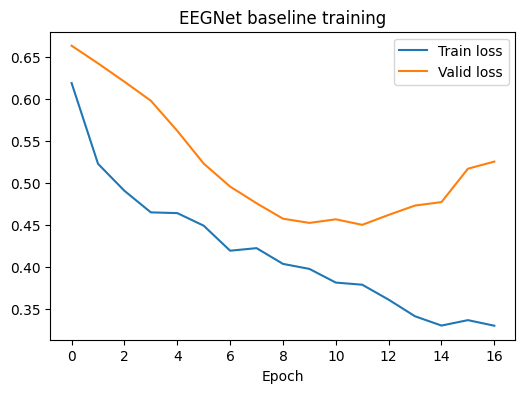

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6241       0.7362        0.6736  0.0005  4.6824
      2        0.5235       0.7660        0.6471  0.0005  4.7578
      3        0.4805       0.7617        0.6267  0.0005  4.7042
      4        0.4709       0.7660        0.6027  0.0005  4.6685
      5        0.4384       0.7745        0.5712  0.0005  4.7200
      6        0.4307       0.7830        0.5424  0.0005  4.6492
      7        0.4118       0.7489        0.5263  0.0005  4.7154
      8        0.3958       0.7830        0.5028  0.0005  4.7410
      9        0.3909       0.7787        0.4920  0.0005  4.7933
     10        0.3761       0.7787        0.4750  0.0005  4.9006
     11        0.3612       0.7617        0.4809  0.0005  4.8192
     12        0.3602       0.7489        0.4785  0.0005  4.7430
     13        0.3423       0.7404        0.5026  0.0005  4.9038
     14        0.3279    

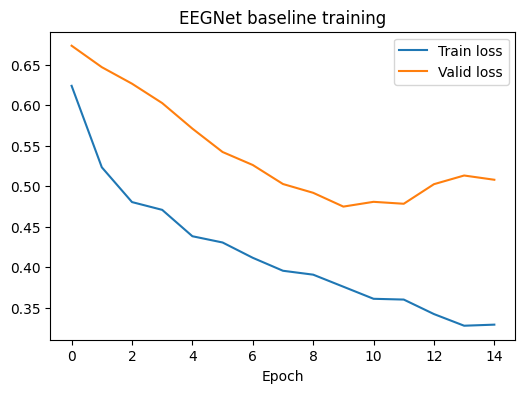

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6086       0.6553        0.6761  0.0005  4.9181
      2        0.5135       0.7149        0.6532  0.0005  4.1913
      3        0.4782       0.7404        0.6326  0.0005  4.9413
      4        0.4601       0.7404        0.6126  0.0005  4.6965
      5        0.4349       0.7404        0.5907  0.0005  4.7922
      6        0.4311       0.7447        0.5741  0.0005  4.6871
      7        0.4337       0.7447        0.5514  0.0005  4.7336
      8        0.4094       0.7660        0.5328  0.0005  4.7240
      9        0.4070       0.7660        0.5233  0.0005  4.6221
     10        0.3822       0.7660        0.5098  0.0005  4.8290
     11        0.3766       0.7702        0.5106  0.0005  5.2996
     12        0.3822       0.7574        0.5108  0.0005  4.7900
     13        0.3564       0.7745        0.5161  0.0005  4.8652
     14        0.3401    

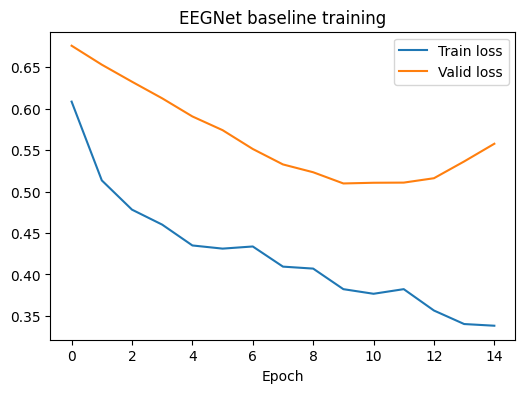

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6083       0.6638        0.6737  0.0005  4.8555
      2        0.5404       0.6936        0.6563  0.0005  4.9306
      3        0.5114       0.6894        0.6435  0.0005  4.8629
      4        0.4874       0.7106        0.6233  0.0005  4.8049
      5        0.4606       0.7149        0.6029  0.0005  4.7108
      6        0.4607       0.6979        0.5825  0.0005  4.6911
      7        0.4532       0.6936        0.5617  0.0005  4.6562
      8        0.4473       0.7106        0.5487  0.0005  4.7090
      9        0.4383       0.6979        0.5525  0.0005  4.6770
     10        0.4299       0.6936        0.5461  0.0005  4.7090
     11        0.4006       0.6894        0.5502  0.0005  4.6557
     12        0.3969       0.7234        0.5499  0.0005  4.6941
     13        0.3836       0.7106        0.5489  0.0005  4.7315
     14        0.3746    

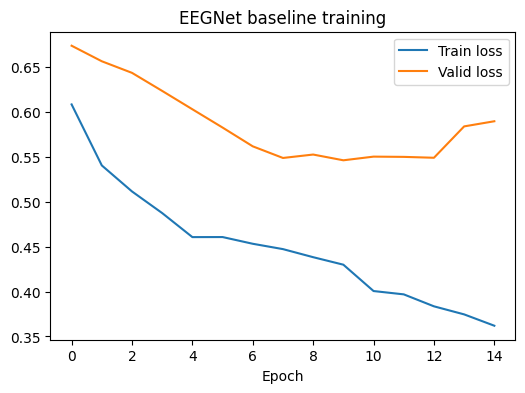

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6281       0.7021        0.6758  0.0005  4.7437
      2        0.5415       0.7362        0.6580  0.0005  4.6755
      3        0.5190       0.7362        0.6470  0.0005  4.8990
      4        0.4988       0.7234        0.6317  0.0005  4.6627
      5        0.4838       0.7191        0.6113  0.0005  4.7235
      6        0.4800       0.7191        0.5956  0.0005  4.7038
      7        0.4620       0.6851        0.5815  0.0005  4.6972
      8        0.4527       0.6979        0.5648  0.0005  4.7023
      9        0.4362       0.7021        0.5515  0.0005  4.6744
     10        0.4367       0.7191        0.5369  0.0005  4.7149
     11        0.4236       0.7064        0.5383  0.0005  4.7568
     12        0.4183       0.6979        0.5391  0.0005  4.6769
     13        0.4056       0.7021        0.5589  0.0005  4.8480
     14        0.3911    

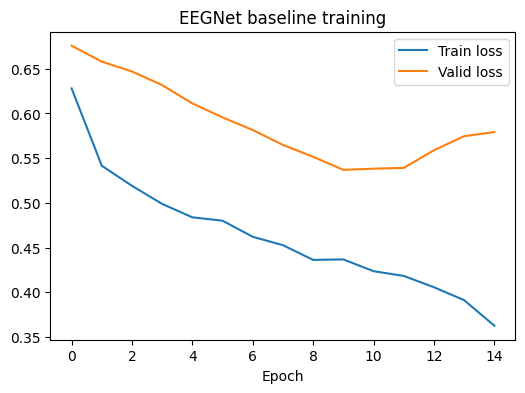

,F1,D,drop,epochs,batch,acc_mean,acc_std,kappa_mean,kappa_std
0,8,2,0.50,30,32,0.751763,0.052743,0.502977,0.105389
1,8,4,0.50,30,32,0.743570,0.047696,0.486820,0.095216
2,8,2,0.25,30,32,0.734687,0.047715,0.468844,0.095630
3,16,4,0.50,30,32,0.727875,0.054049,0.454902,0.108087
4,16,2,0.25,30,32,0.725135,0.032593,0.449537,0.064986
5,16,4,0.25,30,32,0.723784,0.049514,0.446786,0.099098
6,8,4,0.25,30,32,0.723782,0.048535,0.447155,0.097020
7,16,2,0.50,30,32,0.721732,0.043375,0.442648,0.087114


Best (coarse): {'F1': 8.0, 'D': 2.0, 'drop': 0.5, 'epochs': 30.0, 'batch': 32.0, 'acc_mean': 0.7517633674630262, 'acc_std': 0.05274310656010483, 'kappa_mean': 0.5029765838789825, 'kappa_std': 0.10538937939036418}


In [14]:
import numpy as np
import pandas as pd
from itertools import product

grid = {
    "F1":        [8, 16],
    "D":         [2, 4],
    "drop":      [0.25, 0.5],
    "epochs":    [30],      # adjust only if needed
    "batch":     [32],      # keep fixed for now to reduce variance
}

results = []
for F1, D, drop, epochs, batch in product(*grid.values()):
    rows = eval_with_preproc(
        X, y, subjects,
        build_module=lambda: make_eegnet(F1=F1, D=D, drop=drop),
        preproc_pair_fn=zscore_per_trial_pair,
        n_splits=5,
        plot_curves=True,
    )
    accs   = [r["acc"] for r in rows]
    kappas = [r["kappa"] for r in rows]
    results.append({
        "F1": F1, "D": D, "drop": drop, "epochs": epochs, "batch": batch,
        "acc_mean": np.mean(accs), "acc_std": np.std(accs),
        "kappa_mean": np.mean(kappas), "kappa_std": np.std(kappas),
    })

tune_df = pd.DataFrame(results).sort_values("acc_mean", ascending=False).reset_index(drop=True)
display(tune_df.head(10))  # top configs
best = tune_df.iloc[0].to_dict()
print("Best (coarse):", best)


In [ ]:
'F1': 8.0, 'D': 2.0, 'drop': 0.5, 'epochs': 30.0, 'batch': 32.0, 'acc_mean': 0.7517633674630262, 'acc_std': 0.05274310656010483, 'kappa_mean': 0.5029765838789825, 'kappa_std': 0.10538937939036418}

In [15]:
FIGS

PosixPath('/Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs')

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6922       0.6979        0.6780  0.0005  2.0827
      2        0.6240       0.7702        0.6478  0.0005  2.1224
      3        0.5761       0.7617        0.6059  0.0005  401.1290
      4        0.5326       0.7532        0.5675  0.0005  2.4081
      5        0.5183       0.7489        0.5394  0.0005  2.1603
      6        0.5030       0.7532        0.5189  0.0005  2.1923
      7        0.4962       0.7489        0.4998  0.0005  2.0723
      8        0.4717       0.7532        0.4874  0.0005  2.3732
      9        0.4794       0.7574        0.4755  0.0005  2.0023
     10        0.4650       0.7489        0.4719  0.0005  1.9960
     11        0.4636       0.7574        0.4743  0.0005  2.0199
     12        0.4491       0.7574        0.4693  0.0005  2.1664
     13        0.4591       0.7574        0.4733  0.0005  2.0550
     14        0.4479  

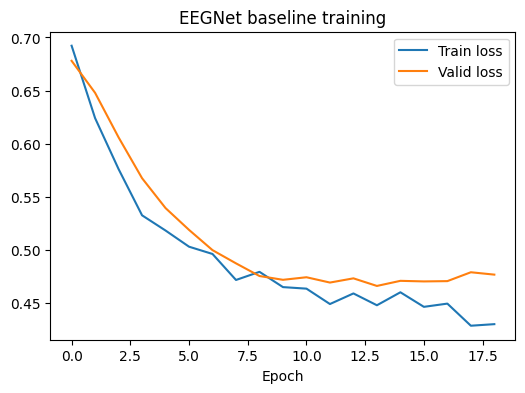

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold0_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6561       0.7362        0.6783  0.0005  2.0621
      2        0.5824       0.7532        0.6423  0.0005  2.0277
      3        0.5432       0.7532        0.6009  0.0005  2.0457
      4        0.5320       0.7702        0.5776  0.0005  2.0469
      5        0.5333       0.7830        0.5540  0.0005  2.1352
      6        0.5010       0.7915        0.5339  0.0005  2.0822
      7        0.5019       0.7915        0.5205  0.0005  1.9930
      8        0.4889       0.7957        0.5055  0.0005  2.0622
      9        0.4846       0.7915        0.4982  0.0005  2.0058
     10        0.4707       0.7872        0.4871  0.0005  1.9869
     11        0.4729       0.7702        0.4819  0.0005  1.9762
     12        0.4571       0.7745     

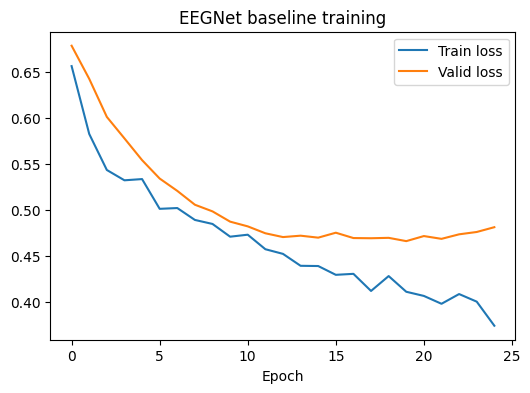

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold1_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6866       0.6511        0.6885  0.0005  1.9961
      2        0.6295       0.6894        0.6689  0.0005  1.9934
      3        0.5619       0.7149        0.6283  0.0005  2.0320
      4        0.5083       0.7234        0.5914  0.0005  1.9836
      5        0.4966       0.7277        0.5638  0.0005  2.0752
      6        0.4897       0.7447        0.5520  0.0005  2.0260
      7        0.4938       0.7362        0.5396  0.0005  1.9962
      8        0.4871       0.7447        0.5321  0.0005  2.0369
      9        0.4722       0.7532        0.5277  0.0005  1.9772
     10        0.4593       0.7447        0.5226  0.0005  1.9945
     11        0.4459       0.7532        0.5201  0.0005  2.0321
     12        0.4498       0.7660     

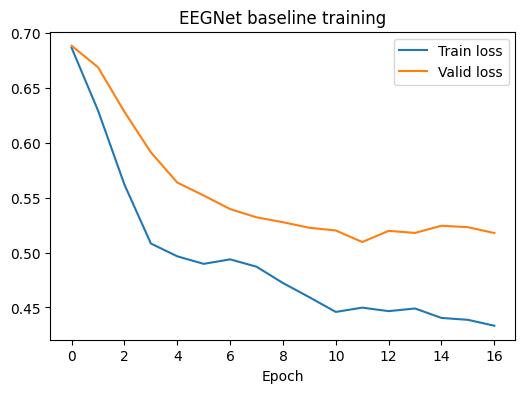

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold2_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7033       0.5745        0.6897  0.0005  2.0367
      2        0.6454       0.6383        0.6742  0.0005  2.0055
      3        0.5765       0.6638        0.6407  0.0005  2.0312
      4        0.5465       0.6723        0.6090  0.0005  2.0046
      5        0.5266       0.7021        0.5880  0.0005  2.0542
      6        0.5324       0.7021        0.5743  0.0005  2.0228
      7        0.5161       0.7021        0.5651  0.0005  2.0506
      8        0.5061       0.6979        0.5544  0.0005  2.0553
      9        0.5045       0.7149        0.5454  0.0005  2.0493
     10        0.5032       0.7064        0.5363  0.0005  2.0056
     11        0.4825       0.6979        0.5404  0.0005  2.0714
     12        0.4829       0.7021     

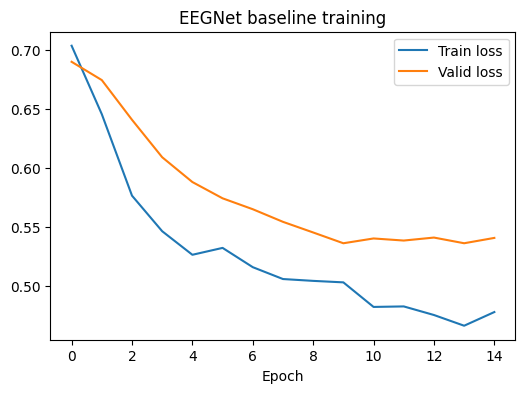

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold3_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7035       0.6553        0.6887  0.0005  2.0196
      2        0.6531       0.7149        0.6715  0.0005  1.9889
      3        0.6148       0.7319        0.6361  0.0005  1.9683
      4        0.5742       0.7191        0.5993  0.0005  1.9851
      5        0.5573       0.7106        0.5816  0.0005  2.0758
      6        0.5432       0.7149        0.5678  0.0005  2.0398


In [ ]:
best_rows = eval_with_preproc(
    X, y, subjects,
    build_module=lambda: make_eegnet(F1=int(best["F1"]), D=int(best["D"]), drop=float(best["drop"])),
    preproc_pair_fn=zscore_per_trial_pair,
    n_splits=5,
    plot_curves=True,
    saveFigs=True,
    filepath=FIGS
)
summarize(best_rows, "EEGNet (best params) + per-trial z-score")


In [ ]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
import numpy as np
import pandas as pd

def loso_final_eval(X, y, subjects, build_module, preproc_pair_fn, label="EEGNet LOSO"):
    """
    Leave-One-Subject-Out evaluation.
    X : (N, C, T)
    y : (N,)
    subjects : (N,) array of subject IDs
    build_module : function that returns a fresh EEG model
    preproc_pair_fn : function(X_train, X_test) -> (X_train_p, X_test_p)
    """
    unique_subs = np.unique(subjects)
    rows = []

    for sub in unique_subs:
        print(f"\n🧠 Testing on subject {sub}...")
        tr_idx = np.where(subjects != sub)[0]
        te_idx = np.where(subjects == sub)[0]

        Xtr, Xte = X[tr_idx], X[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]

        # preprocessing (safe: uses only train stats)
        Xtr_p, Xte_p = preproc_pair_fn(Xtr, Xte)

        # build and train
        clf = make_eeg_clf(build_module())
        clf.fit(Xtr_p, ytr)

        # predict on test subject
        yhat = clf.predict(Xte_p)
        acc = accuracy_score(yte, yhat)
        kappa = cohen_kappa_score(yte, yhat)

        rows.append(dict(sub=sub, acc=acc, kappa=kappa, n_test=len(yte)))
        print(f"   acc={acc:.3f}, κ={kappa:.3f}")

    df = pd.DataFrame(rows)
    print(f"\n{label}: acc {df.acc.mean():.3f}±{df.acc.std():.3f} | κ {df.kappa.mean():.3f}±{df.kappa.std():.3f}")
    return df


In [ ]:
# Final hold-out per subject (LOSO)
df_loso = loso_final_eval(
    X, y, subjects,
    build_module=lambda: make_eegnet(F1=8, D=2, drop=0.25),
    preproc_pair_fn=zscore_per_trial_pair,
    label="EEGNet + per-trial z-score (LOSO final test)"
)



🧠 Testing on subject 1...
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5627       0.7509        0.5254  0.0100  2.3966
      2        0.5045       0.7474        0.5130  0.0100  2.3957
      3        0.4898       0.7235        0.5444  0.0100  2.3931
      4        0.4698       0.7406        0.5290  0.0100  2.5476
      5        0.4419       0.7270        0.5649  0.0100  2.3534
      6        0.4425       0.7065        0.6060  0.0100  2.3783
Stopping since valid_loss has not improved in the last 5 epochs.
   acc=1.000, κ=1.000

🧠 Testing on subject 2...
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5663       0.7569        0.4879  0.0100  2.4632
      2        0.5162       0.7500        0.4897  0.0100  2.3281
      3        0.5141       0.7639        0.4984  0.0100  2.3431
      4       

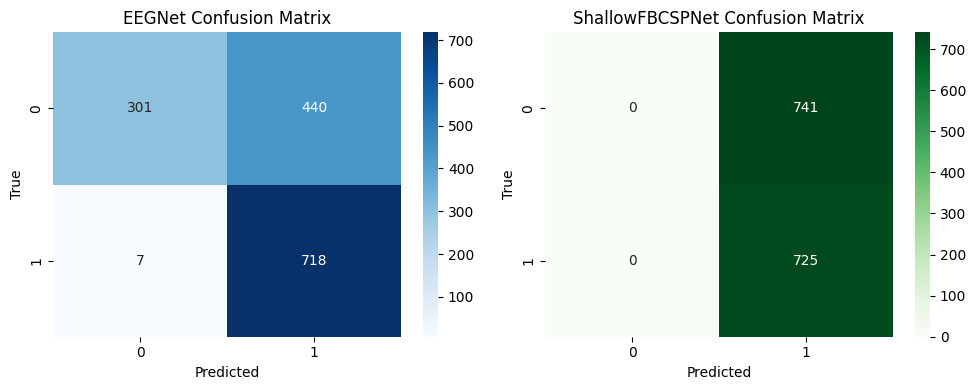

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm_eegnet = confusion_matrix(y, y_pred_eegnet)
cm_shallow = confusion_matrix(y, y_pred_shallow)
f, ax = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(cm_eegnet, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('EEGNet Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
sns.heatmap(cm_shallow, annot=True, fmt='d', ax=ax[1], cmap='Greens')
ax[1].set_title('ShallowFBCSPNet Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
plt.tight_layout()
plt.show()#savefig(FIGS / "confusion_matrices.png", dpi=300)   

In [ ]:
# Visualize learned temporal kernel of EEGNet
import matplotlib.pyplot as plt
weights = clf.module_.conv_temporal.weight.detach().cpu().numpy()[0]
plt.plot(weights[0]); plt.title("Temporal kernel – EEGNet"); plt.tight_layout()
# plt.savefig("../figs/day7_eegnet_kernel.png",dpi=150)
plt.show()
